In [1]:
import os

midras_key = os.getenv("MIDRAS_API_KEY")
qdrant_host = os.getenv("QDRANT_HOST")
qdrant_key = os.getenv("QDRANT_API_KEY")

In [2]:
from qdrant_client import QdrantClient

from midrasai import Midras

midras = Midras(api_key=midras_key)
qdrant = QdrantClient(":memory:")

In [3]:
midras.embed_text(["This is a test"])

MidrasResponse(credits_spent=1, embeddings=[[[-0.042236328125, 0.091796875, -0.052978515625, 0.058349609375, 0.07958984375, -0.08984375, 0.036865234375, -0.042236328125, -0.033203125, -0.0771484375, -0.09912109375, -0.002349853515625, 0.08984375, -0.0218505859375, 0.07080078125, 0.1904296875, 0.1865234375, 0.0233154296875, 0.0038604736328125, -0.052734375, 0.173828125, -0.10400390625, -0.01080322265625, -0.013671875, -0.1279296875, -0.0615234375, 0.00830078125, -0.138671875, 0.10302734375, -0.06884765625, -0.0294189453125, -0.06640625, 0.00830078125, 0.0869140625, -0.0172119140625, -0.007781982421875, 0.08203125, -0.11962890625, -0.051025390625, -0.1865234375, 0.03369140625, -0.003692626953125, -0.10302734375, 0.08544921875, -0.0308837890625, -0.01214599609375, 0.11474609375, -0.016845703125, 0.0255126953125, -0.045166015625, 0.1259765625, 0.018798828125, 0.1728515625, -0.035400390625, 0.0177001953125, -0.173828125, 0.0400390625, 0.062255859375, 0.054931640625, -0.057373046875, 0.01483

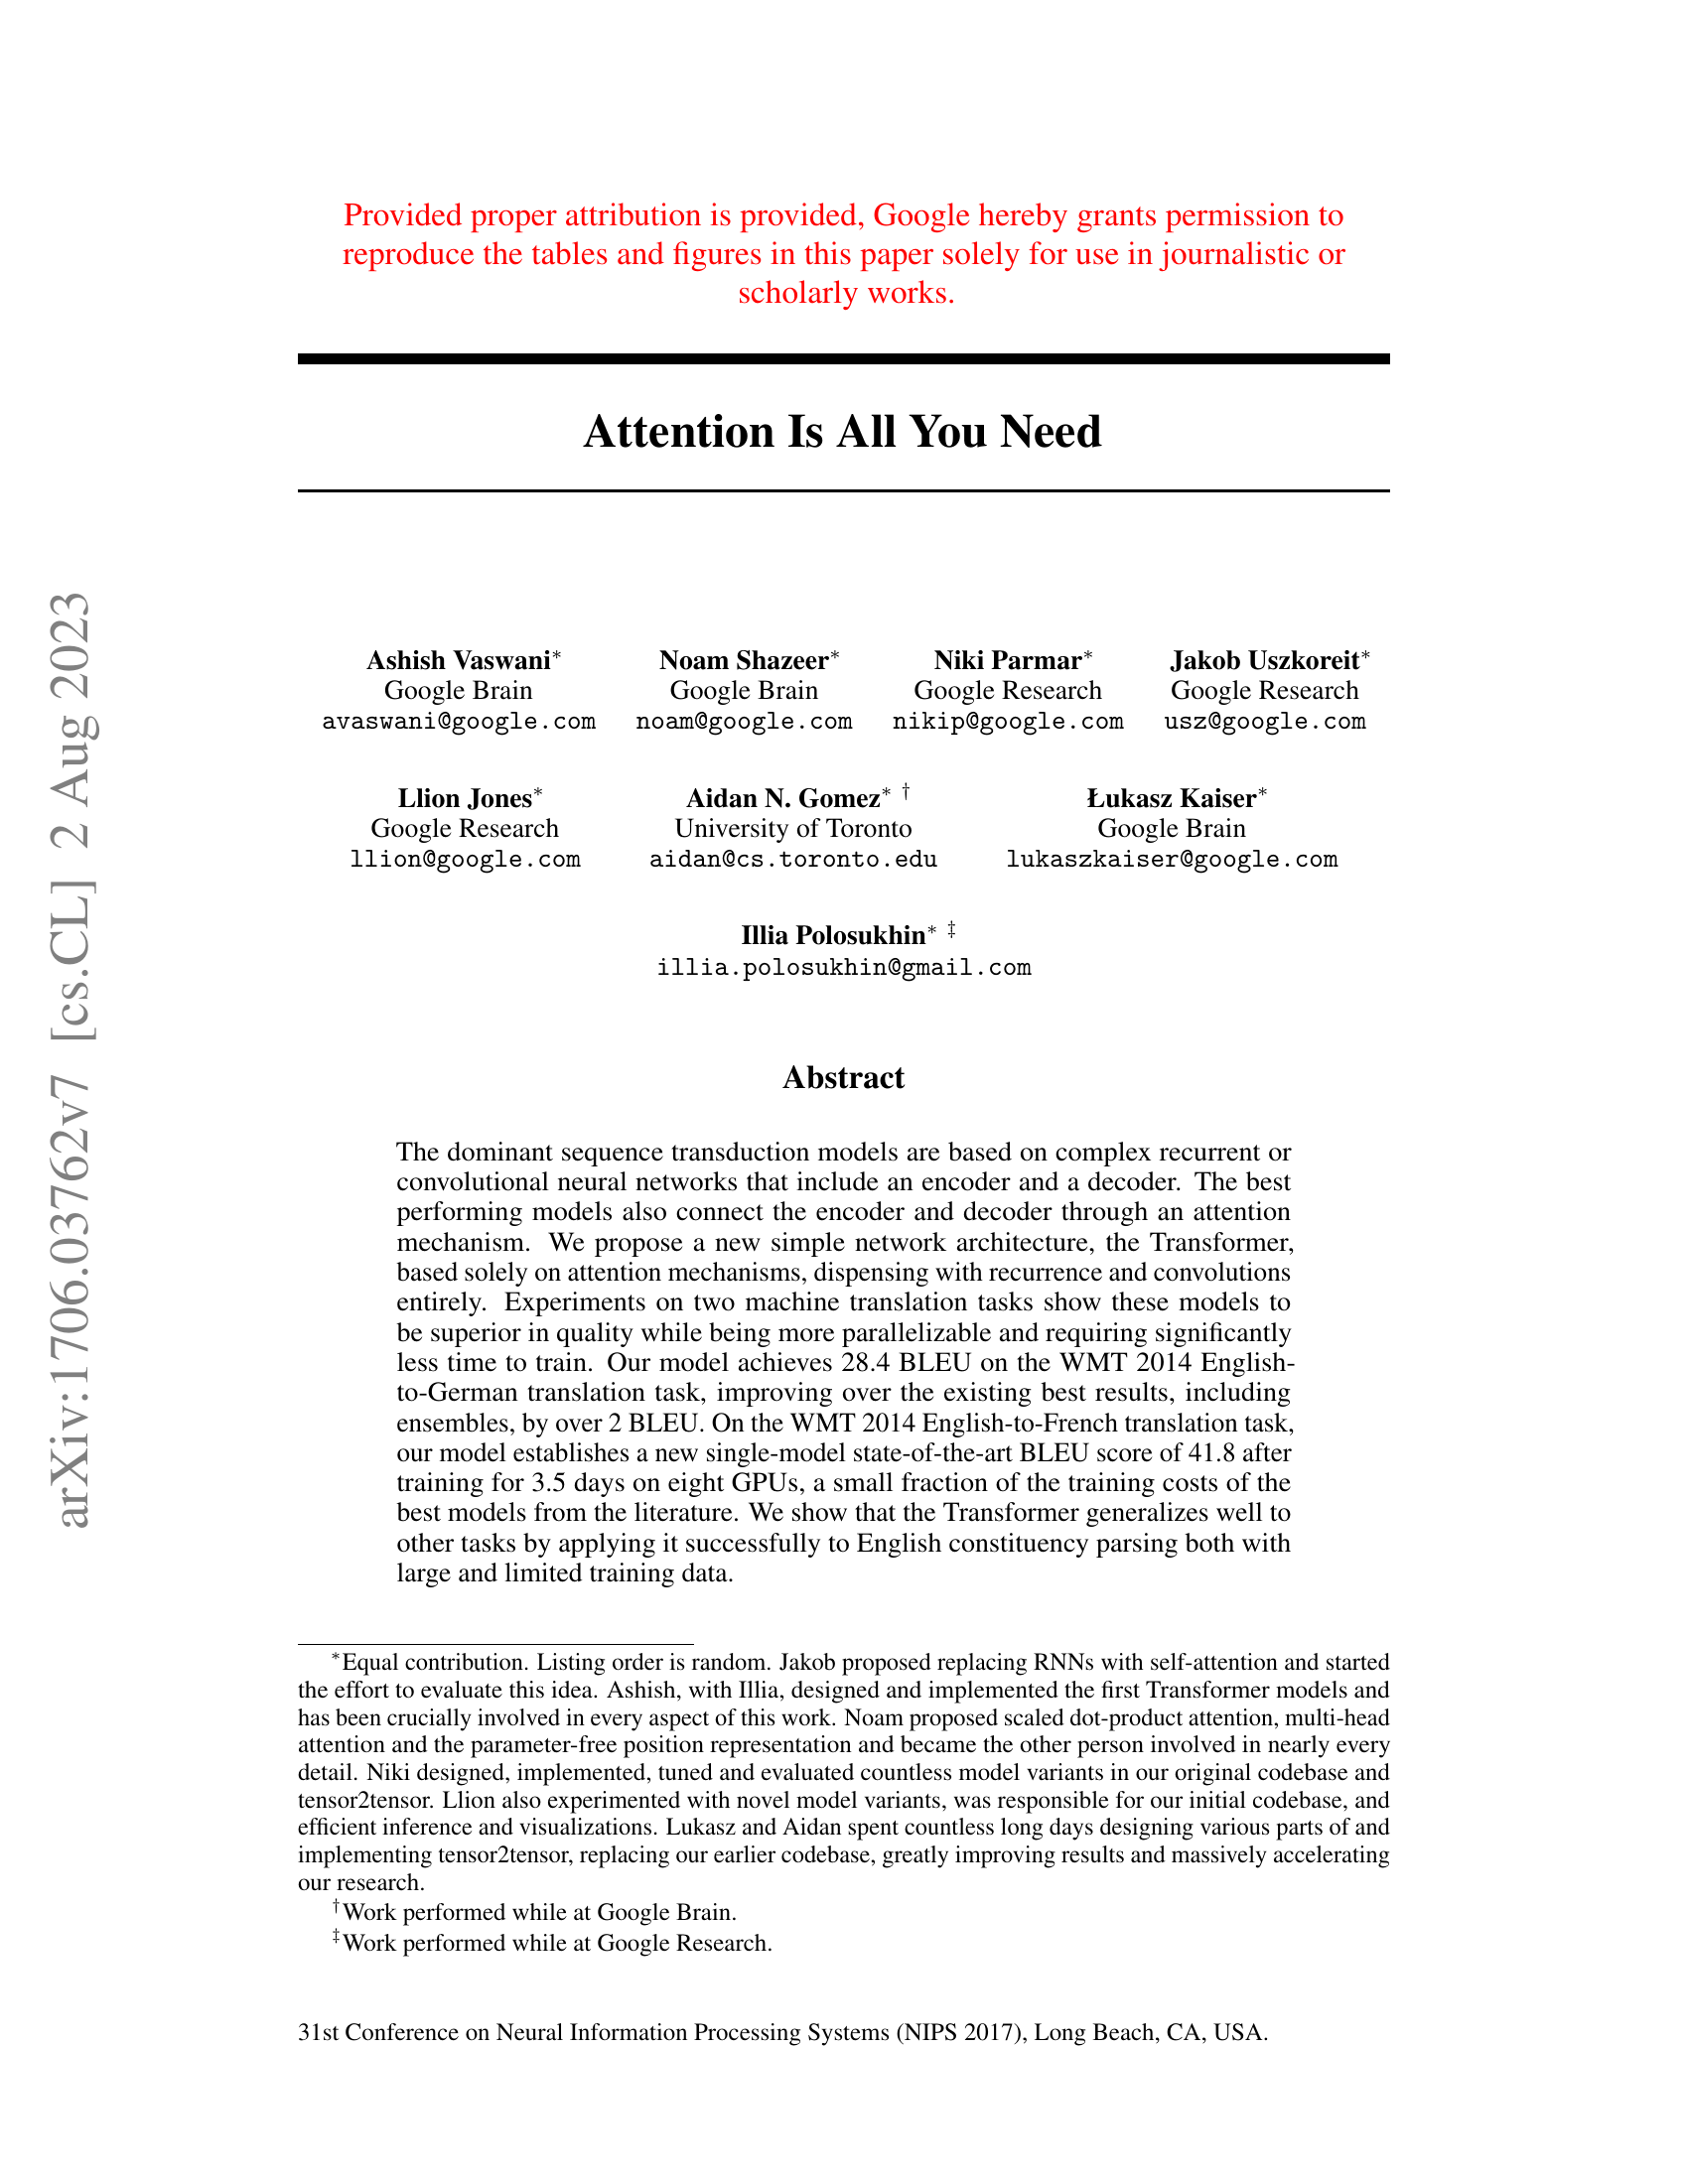

In [4]:
import os

from pdf2image import convert_from_path

DIR = os.path.dirname(os.path.abspath(__name__))

images = convert_from_path(DIR + "/Attention_is_all_you_need.pdf")
images[0]

In [5]:
len(images)

15

In [6]:
embeddings = []
batch_size = 10
for i in range(0, len(images), batch_size):
    image_batch = images[i : i + batch_size]
    response = midras.embed_pil_images(image_batch)
    embeddings.extend(response.embeddings)

In [9]:
from qdrant_client import models

COLLECTION = "AIAYN"

qdrant.create_collection(
    collection_name=COLLECTION,
    vectors_config=models.VectorParams(
        size=128,
        distance=models.Distance.COSINE,
        multivector_config=models.MultiVectorConfig(
            comparator=models.MultiVectorComparator.MAX_SIM
        ),
    ),
)

True

In [13]:
points = []
for i in range(len(images)):
    point = models.PointStruct(
        id=i, payload={"page_number": i + 1}, vector=embeddings[i]
    )
    points.append(point)

qdrant.upsert(COLLECTION, points)

UpdateResult(operation_id=0, status=<UpdateStatus.COMPLETED: 'completed'>)

In [21]:
query = input()

query_embedding = midras.embed_text([query]).embeddings

result = qdrant.query_points(COLLECTION, query=query_embedding[0])

In [34]:
print("Top 3 relevant pages:", end=" ")
relevant_pages = []
for point in result.points[:3]:
    page_number = point.payload["page_number"]
    print(page_number, end=", ")
    relevant_pages.append(page_number)

Top 3 relevant pages: 1, 2, 0, 

Image 1:


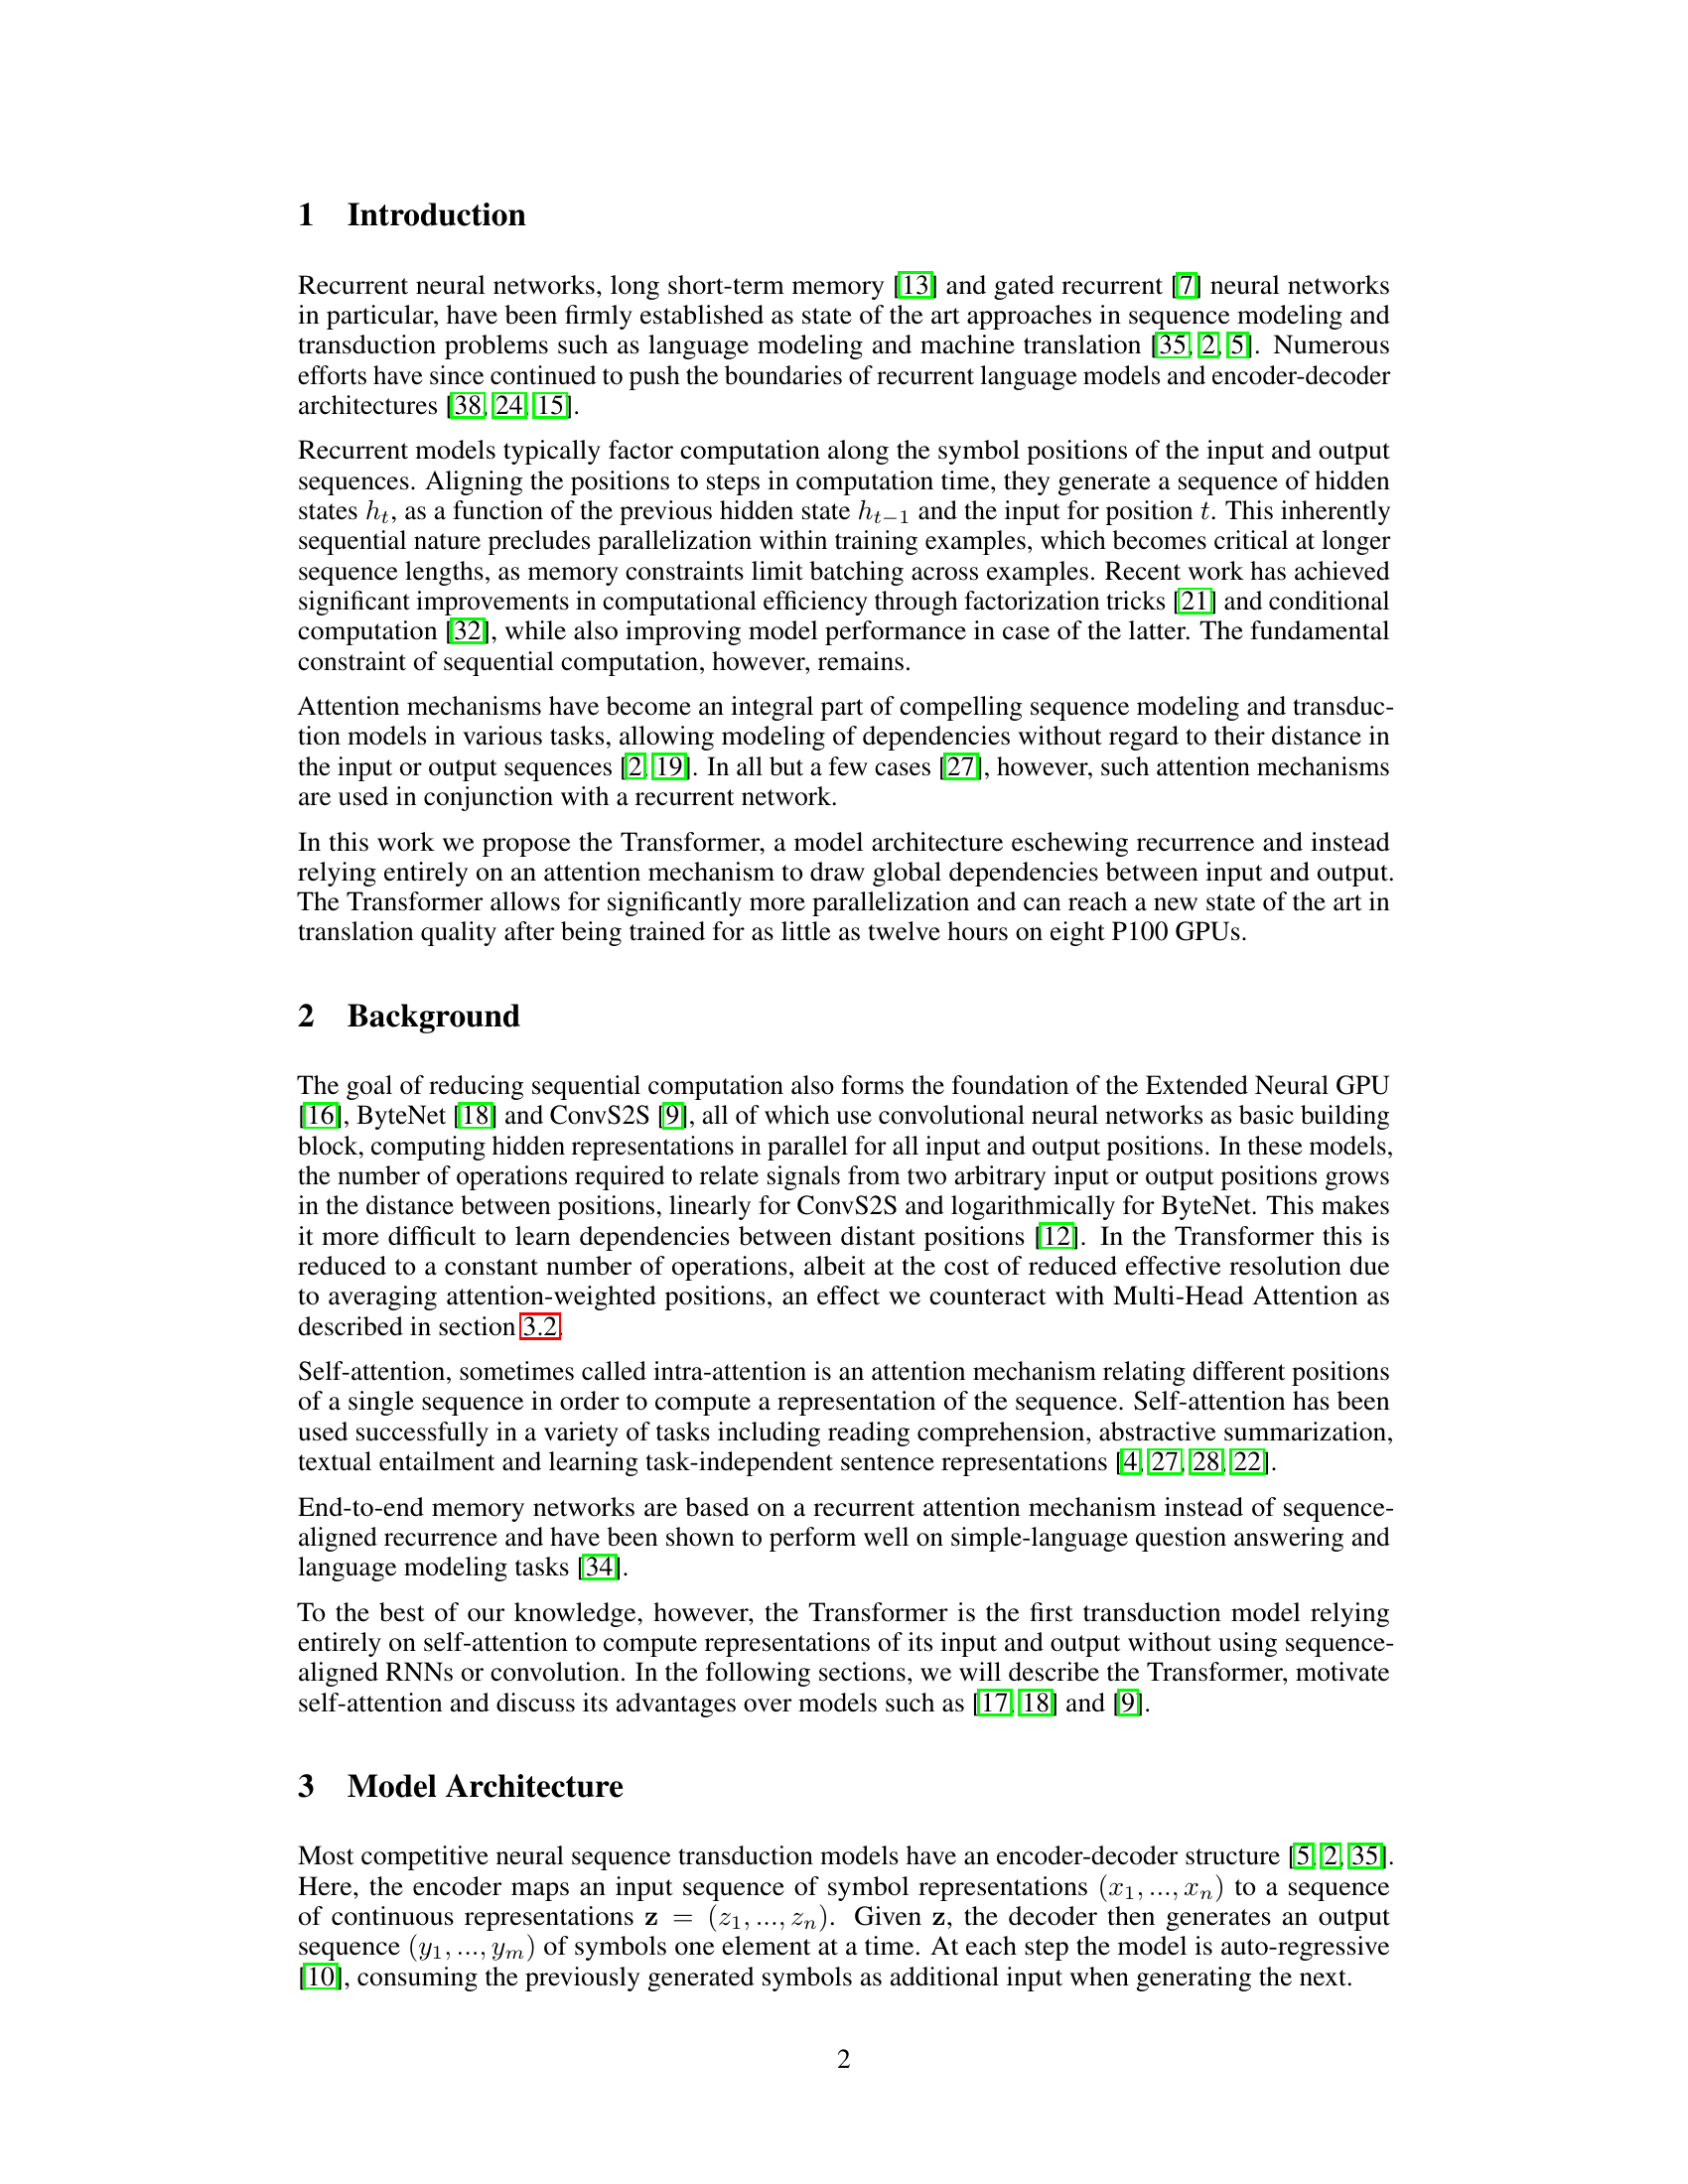



Image 2:


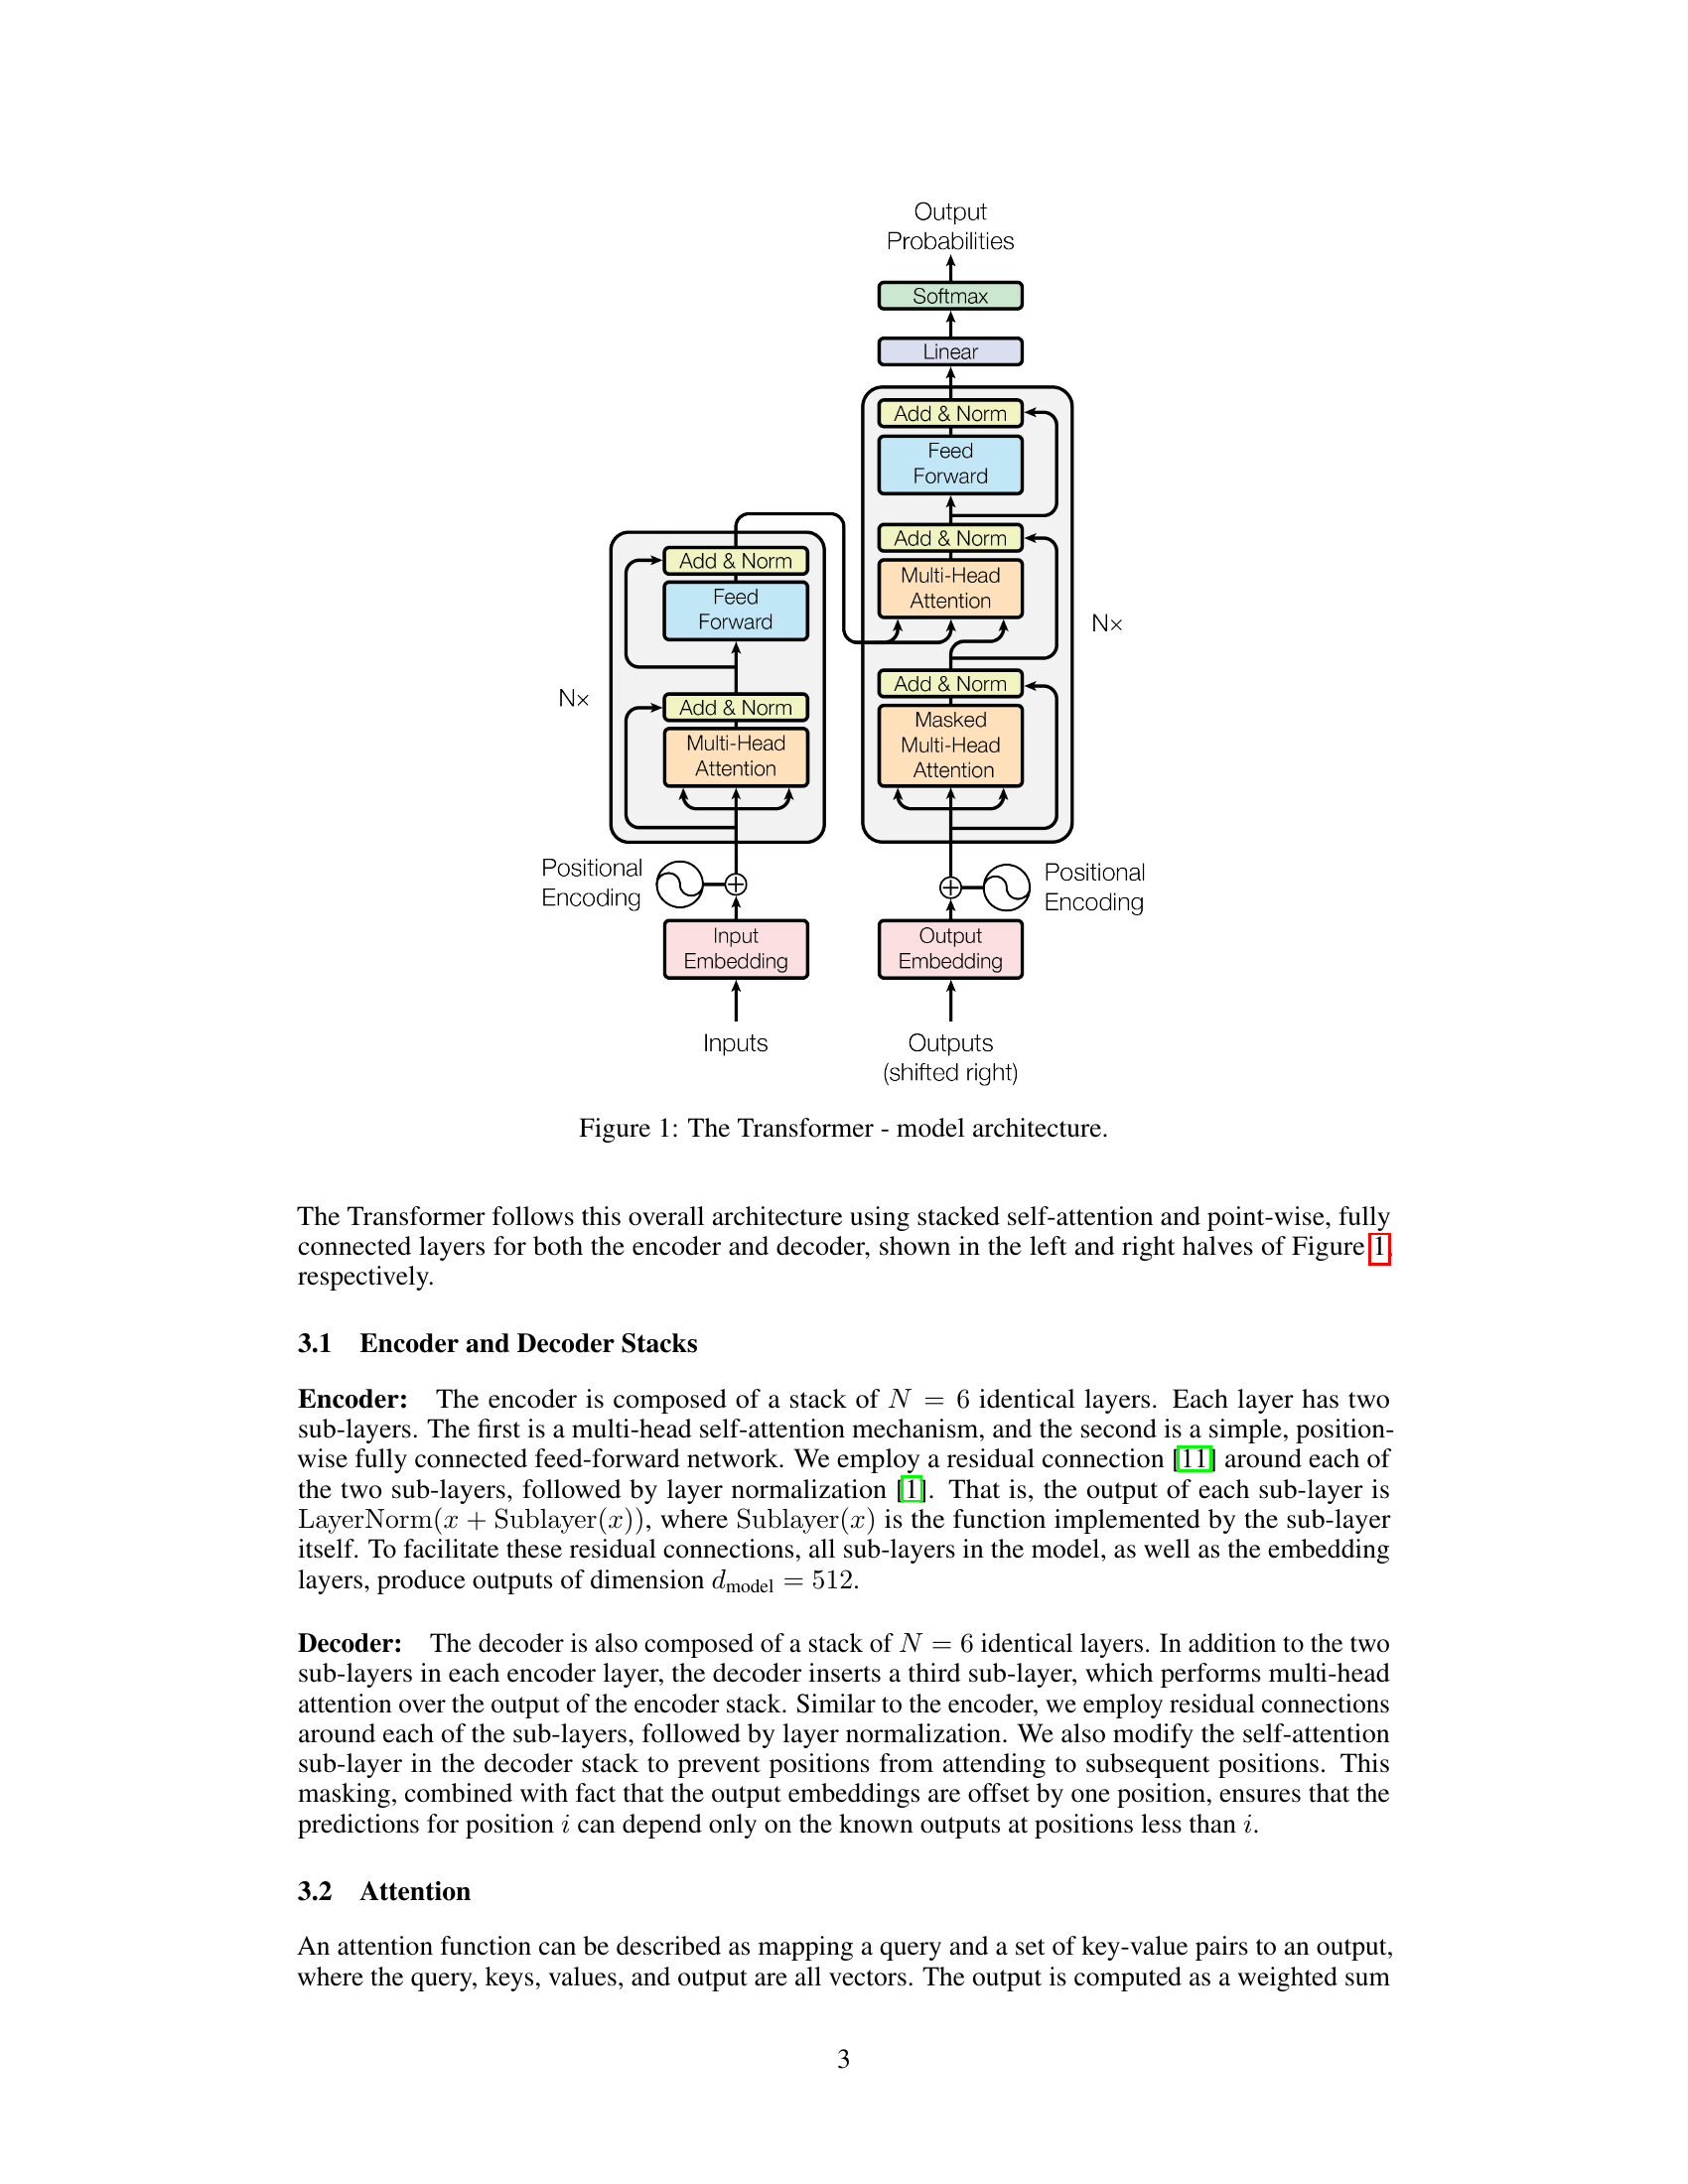



Image 3:


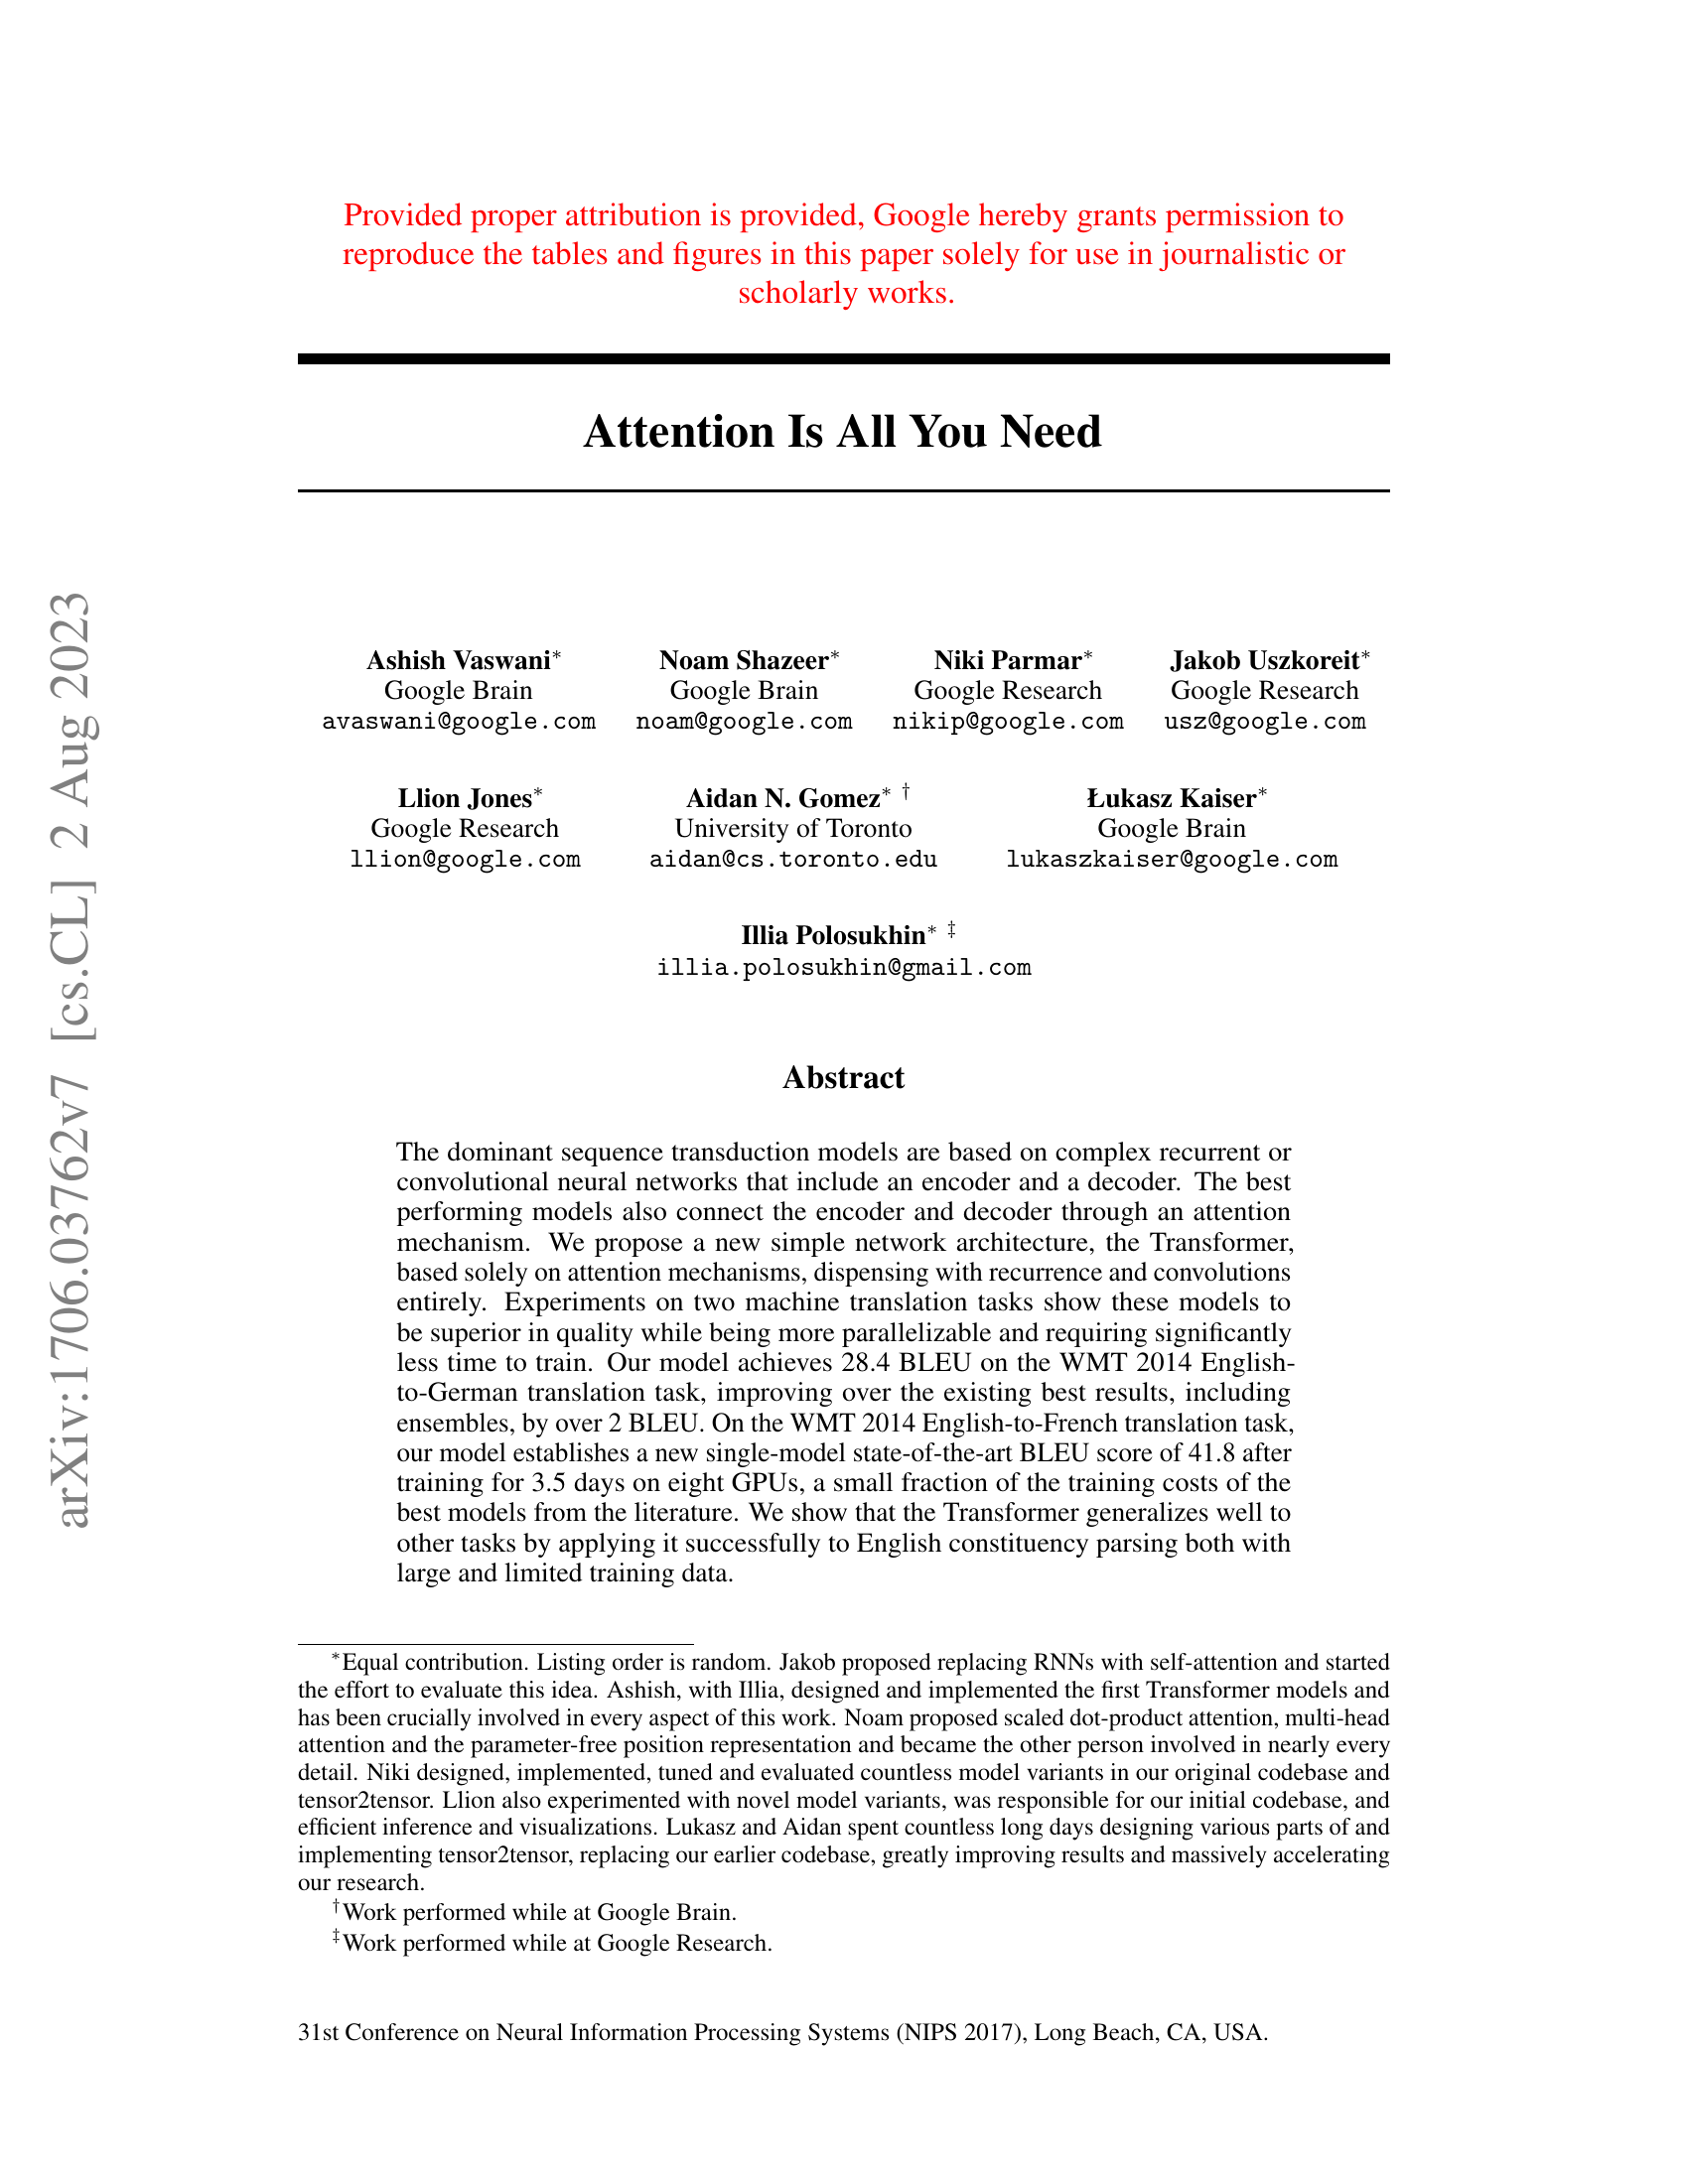

In [37]:
from IPython.display import display

# Display images 1, 2, and 0 in that order
for number, index in enumerate(relevant_pages):
    print(f"Image {number + 1}:")
    display(images[index])
    print("\n")  # Add a newline for better separation between images